<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/thesis_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget file.weasoft.com/images.zip
!wget file.weasoft.com/summary.csv
!git clone https://github.com/suanfaxiaohuo/SwinOCSR.git
!pip install focal_loss_torch wandb
!pip3 install deepsmiles yacs tqdm
!wget file.weasoft.com/model.py -O model.py
!wget file.weasoft.com/reverse.map

--2024-03-19 23:51:42--  http://file.weasoft.com/images.zip
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461037456 (440M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>] 439.68M  64.4MB/s    in 7.1s    

2024-03-19 23:51:50 (61.8 MB/s) - ‘images.zip’ saved [461037456/461037456]

--2024-03-19 23:51:50--  http://file.weasoft.com/summary.csv
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 716523 (700K) [text/csv]
Saving to: ‘summary.csv’

summary.csv         100%[===================>] 699.73K  2.51MB/s    in 0.3s    

2024-03-19 23:51:50 (2.51 MB/s) - ‘summary.csv’ saved [716523/716523]

Cloning into 'SwinOCSR'...
remote: Enumerating objects: 453

In [3]:
!unzip images.zip

Archive:  images.zip
  inflating: 10952_050583472155929066.png  
  inflating: 10952_06413864577904915.png  
  inflating: 10952_0987733374849662.png  
  inflating: 10952_10418284106334552.png  
  inflating: 10952_16580034422892975.png  
  inflating: 10952_23370361265754647.png  
  inflating: 10952_2592774190030849.png  
  inflating: 10952_46352491565819787.png  
  inflating: 10952_5437104182840758.png  
  inflating: 10952_7528510827860566.png  
  inflating: 10952_8472447206478343.png  
  inflating: 10952_9943772215519315.png  
  inflating: 11182_009797678782551.png  
  inflating: 11182_056521676103760465.png  
  inflating: 11182_06305573566312661.png  
  inflating: 11182_06673381672094503.png  
  inflating: 11182_09202768527861127.png  
  inflating: 11182_09932843308058081.png  
  inflating: 11182_10408978036627115.png  
  inflating: 11182_10983032013014726.png  
  inflating: 11182_1262978826120098.png  
  inflating: 11182_1314325210419437.png  
  inflating: 11182_17841757812291215.png 

In [4]:
!mkdir -p images
!mv *.png images
!mv *.webp images

In [5]:
from model import *

In [6]:
import torch, torchvision
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
# mod = torch.load("drive/MyDrive/large_set.7.pt", map_location=device)
mod = torch.load("drive/MyDrive/final.98.pt", map_location=device) #duzikunkkiknow why i need to /255
#

In [7]:
t = 1
import deepsmiles
from PIL import Image
import json


converter = deepsmiles.Converter(rings=True, branches=True)
def triangle_mask(size):
    mask = 1- np.triu(np.ones((1, size, size)),k=1).astype('uint8')
    mask = torch.autograd.Variable(torch.from_numpy(mask))
    return mask

def top_k_2d(m, k):
  values, indices = torch.topk(m.flatten(), k)
  return indices//m.shape[1], indices%m.shape[1]

def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch, maxlen

reversed_word_map = {}

with open("reverse.map","r") as f:
  reversed_word_map = json.loads(f.read())
reversed_word_map_={}

for i in reversed_word_map.keys():
  reversed_word_map_[int(i)] = reversed_word_map[i]


In [34]:
import numpy as np
import os
import random
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.out = []

  def predict_next(self, i, out, beam, r):
    reward = torch.zeros(self.top_n_p.shape)
    if i>1:
      for j in range(beam):
        if self.top_n[j][-1]==78:
          out[j]=torch.zeros(79)
          out[j][78]=1
          reward[j]=(0.)
        else:
          reward[j]=(r)
    self.top_n_p+=reward.to(device)
    tmp_n = self.top_n_p.repeat((79,1)).T+torch.log(out)
    x, y = top_k_2d(tmp_n, beam)
    new_top_n = []
    new_top_n_p = []
    for j in range(beam):
      new_top_n.append(torch.cat((self.top_n[x[j]], y[j].cpu().unsqueeze(-1))))
      new_top_n_p += [tmp_n[x[j], y[j]]]
    self.top_n = new_top_n
    self.top_n_p = torch.tensor(new_top_n_p).to(device)


  def forward(self, images, text_in_, max_len, beam, method = "voting",r=0.05): #just changed beam=1 and it runs so beam cannot be random number???  yeah it has to been factor of 676, which is 2 2 13 13 but original paper did not use beam search
    with torch.no_grad():
      image_feature = []
      for i in images:
        mem = self.decoder.encoder(self.decoder.encoder_dim(self.encoder(i/255)))
        mem = mem.repeat_interleave(beam, dim=0)
        image_feature.append(mem)


      self.top_n = torch.tensor(text_in_)
      self.top_n_p = torch.tensor([0.]).to(device)
      for i in range(max_len):
        padded_text , l = pad_pack(self.top_n)
        padded_text = padded_text.to(device)
        out = []
        for j in range(len(images)):
          out.append(self.decoder.decoder(padded_text, image_feature[j], x_mask=triangle_mask(l).to(device))[:,-1,:].squeeze(dim=1))
        self.out.append(torch.stack(out))
        if method == "sum":
          for j in range(len(out)):
            out[j] = torch.nn.functional.softmax(out[j], dim=1)
          out = torch.mean(torch.stack(out), dim=0)
        elif method == "voting":
          for j in range(len(out)):
            out[j] = torch.nn.functional.softmax(out[j]*1000, dim=1)
          out = torch.mean(torch.stack(out), dim=0)
        else:
          print("BOOOM")
          raise TypeError()
        self.predict_next(i, out, beam, r)
        count = 0
        for i in self.top_n:
          if 78 in i:
            count+=1
        if count==beam:
          return self.top_n, self.top_n_p
      return self.top_n, self.top_n_p

val_cids = [286]#, 6587, 6562, 11203]
val_names = [i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cids]


mod = mod.eval()
gen = SMILESGenerator(mod.encoder, mod.decoder)
img1 = torch.tensor(np.array(Image.open("images/"+random.choice(val_names)).convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32)
gen = gen.train(False) #forgot gen=
res = gen.forward([img1], [[77]], 100, 10, "voting", 0)
print()
for i in res[0]:
  print(converter.decode("".join([reversed_word_map_[i] for i in i.numpy()])))
print(torch.exp(res[1]))



<start>C(C(=O)O)ON<end><end>
<start>C(C(=O)O)ON<end>c
<start>C(C(=O)O)ON<end>
<start>C(C(=O)O)ON<end>O
<start>C(C(=O)O)ON<end>N
<start>C(C(=O)O)ON<end><pad>
<start>C(C(=O)O)ON1<end>1
<start>C(C(=O)O)ON<end>
<start>C(C(=O)O)ON<end>S
<start>C(C(=O)O)ON<end>C
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


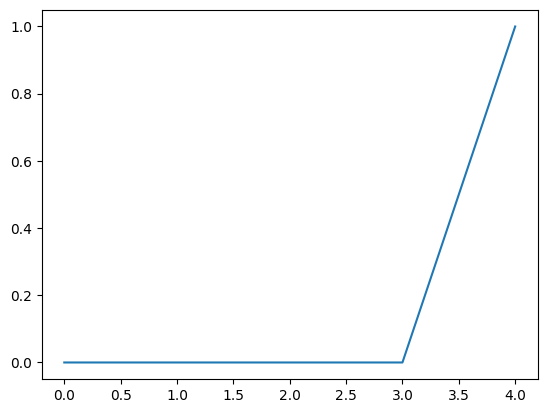

In [22]:
import pylab
def softmax(x):
  t = np.exp(np.array(x)*10)
  return t/np.sum(t)
pylab.plot(softmax([1,0,2,3,5]))

In [ ]:
val_names

In [1]:
pylab.plot(torch.stack(gen.out[1:])[0,0,0].cpu().detach().t())

NameError: name 'pylab' is not defined

In [28]:
def myeval(img_paths, beam, method, r):
  global gen
  if type(img_paths)!=list:
    img_paths = [img_paths]
  imgs = []
  for img_path in img_paths:
    imgs.append(torch.tensor(np.array(Image.open(img_path).convert("RGB").resize((400,400)))).unsqueeze(0).permute(0,3,1,2).to(device).to(torch.float32))
  gen = SMILESGenerator(mod.encoder, mod.decoder)
  gen = gen.train(False)
  res = gen.forward(imgs, [[77]], 100, beam, method, r=r)
  ans = ""
  for i in range(beam):
    ans+=converter.decode("".join([reversed_word_map_[i.item()] for i in res[0][i]]))+"\n"
  return ans.replace("<start>","").replace("<end>","")

In [30]:
import pandas as pd
molecules_rows = pd.read_csv("summary.csv")

In [ ]:
val_cids = test_cids = [286, 6587, 6562, 11203]

beam_ans = []
for nImages in range(1,6):
  count = 0
  for val_cid in val_cids:
    val_cid = [val_cid]
    for sample in range(5):
      val_names = list(["images/"+i for i in np.random.choice([i for i in os.listdir("./images") if int(i.split("_")[0]) in val_cid], nImages, replace=False)])
      correct = molecules_rows[molecules_rows[" cid"]==val_cid[0]]["canonicalsmiles"].item()
      predicted = myeval(val_names, 3, "voting", r=0)
      count = count+1 if correct in predicted.split("\n")[:3] else count
  beam_ans.append(count)


In [15]:
predicted

'NN\nNNN\nNNNNN\n'

In [12]:
beam_ans

[0, 0, 0, 0, 0]

In [ ]:
import pylab
pylab.rcParams['text.usetex'] = False
pylab.plot(np.arange(1,6),np.array(beam_ans)/(len(val_cids)*5))
pylab.scatter(np.arange(1,6),np.array(beam_ans)/(len(val_cids)*5))
pylab.xlabel("Number of images")
pylab.ylabel("Top 3 seq accuracy")
print(beam_ans)
print(beam_ans)